In [14]:
import pandas as pd
from tqdm import tqdm
import jieba
import jieba.posseg
import jieba.analyse
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use({'figure.figsize':(12, 12)}) # 画布大小
sns.set_style('whitegrid')  # 风格样式
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [38]:
# info_path='./data/diff_people_comment/kmeans_add_node_info/figure/'
data_path='../../../data/'
# info_path='./data/diff_people_comment/kmeans_graph_sage_add_info/figure/'
# comment_path='./data/diff_people_comment/'
comment=pd.read_csv(f"{data_path}comment.csv", encoding='utf_8_sig' )
comment_user=set(comment['author_user_name'])
result=pd.read_csv(f"../../../cluster/node_result.csv", encoding='utf_8_sig' )
result=result.loc[result['author_user_name'].isin(comment_user)]

# 文档级处理
- concat reply object

In [40]:
def clean_comment(df):
    print(df.shape[0])
    df.dropna(subset=['reply','reply_content'],inplace=True)
    df.drop_duplicates(subset=['reply','reply_content'],inplace=True)
    df.drop(df[df['reply']==df['reply_content']].index,inplace=True)
    # 剔除回复不是主题的评论
    df.drop(df.loc[df['reply_content'].str.contains('回复.*?[：:]', regex=True)].index,inplace=True)
    df.drop(df.loc[df['reply'].str.len()<=1].index,inplace=True)
    for index,string in tqdm(df.loc[df['reply'].str.contains('回复：', regex=True)]['reply'].items()):
        df.at[index,'reply']=string[3::]
    print(df.shape[0])
    ###
    df['sentences']=df['reply']+ ' ' +df['reply_content']
    df['sentences']=df['sentences'].str.lower() # 转化为小写字母
    # _sentences = df['sentences'].values.tolist()
    # with open('./data/all_comment.txt', 'w', encoding='UTF-8') as fp:
    #     for row in tqdm(_sentences):
    #         fp.write(row + '\n')
    # print('saved the comment!!!')

clean_comment(comment)

70392
70379


0it [00:00, ?it/s]


In [49]:
# print(comment.loc[comment['reply'].str.len()==0])
tmp=(comment.loc[comment['reply'].duplicated()])

In [72]:
tmp=comment.groupby('reply')['reply_content'].apply(list).reset_index(name='concat_reply_content')

In [78]:
concat_comment=pd.DataFrame(columns=['author_user_name','bar_name','reply','reply_content'])

for name,group in tqdm(comment.groupby('author_user_name')):
    for n,g in group.groupby('reply'):
        index=concat_comment.shape[0]
        if g.shape[0]<=1:
            row=[g.iloc[0]['author_user_name'],g.iloc[0]['bar_name'],g.iloc[0]['reply'],g.iloc[0]['reply_content']]
            concat_comment.loc[index]=row
        else: # concat reply reply_content
            # print(g.shape[0])
            # print(g['reply_content'].to_list())
            row=[g.iloc[0]['author_user_name'],g.iloc[0]['bar_name'],g.iloc[0]['reply']]
            row.append('。'.join(g['reply_content'].to_list()))
            concat_comment.loc[index]=row

    # break

100%|██████████| 7899/7899 [02:38<00:00, 49.97it/s] 


In [80]:
clean_comment(concat_comment)
concat_comment.to_csv('concat_comment.csv',index=False,encoding='utf_8_sig')

49522
49522


0it [00:00, ?it/s]


# 添加词到自定义词典

In [ ]:
# import re
# tmp=comment['sentences'].apply(lambda x: re.findall('([米][a-zA-Z0-9]+)',x)).tolist()
# phone_brand=[]
# for i in tmp:
#     phone_brand.extend(i)
# phone_brand=set(phone_brand)
# with open('./data/user_dict.txt', 'a+', encoding='UTF-8') as fp:
#     fp.write('\n')
#     for row in tqdm(phone_brand):
#         fp.write(row +' n'+ '\n')

# 去停用词函数定义

In [82]:
import os
# 创建停用词列表
def stopwordslist():
    stopwords = [line.strip() for line in open('stop_words.txt',encoding='UTF-8').readlines()]
    return stopwords

# 对句子进行中文分词
def seg_depart(sentence):
    # 对文档中的每一行进行中文分词
    sentence_depart = jieba.cut(sentence.strip())
    outstr = ''
    # 去停用词
    for word in sentence_depart:
        if word not in stopwords:
            if word != '\t':
                outstr += word
                outstr += " "
    return outstr

# 创建一个停用词列表
stopwords = stopwordslist()

# 对每一类人的评论进行保存，去停用词，分词
# 供下游任务使用

In [83]:
print(len(result['kmeans_graph_sage_add_info'].unique()))

4


In [87]:
user_list={}
for target in ['kmeans_graph_sage_add_info','kmeans_add_info']:
# for target in ['kmeans_add_node_info']:
    for name,group in tqdm(result.groupby(target)):
        # user_list[name]=set(group['author_user_name'])
        tmp=concat_comment.loc[concat_comment['author_user_name'].isin(set(group['author_user_name']))]
        _sentences = tmp['sentences'].values.tolist()
        with open(f'./data/comment{name}.txt', 'w', encoding='UTF-8') as fp:
                for row in _sentences:
                    fp.write(row + '\n')
        ### delimited words
        with open(f'./data/comment{name}_delimited.txt', 'w', encoding='UTF-8') as fp:
            for line in _sentences:
                line_seg = seg_depart(line)
                fp.write(line_seg + '\n')
        print(f'{name}类有{tmp.shape[0]}条评论,写入完成!!!   去除停用词,分词成功!!!')
        # break
    break

100%|██████████| 4/4 [00:36<00:00,  9.71s/it]


0类有24957条评论,写入完成!!!   去除停用词,分词成功!!!
1类有13520条评论,写入完成!!!   去除停用词,分词成功!!!
2类有7780条评论,写入完成!!!   去除停用词,分词成功!!!
3类有3265条评论,写入完成!!!   去除停用词,分词成功!!!


# 多文档文档使用TF-IDF提取关键词

comment0_delimited.txt
comment1_delimited.txt
comment2_delimited.txt
comment3_delimited.txt


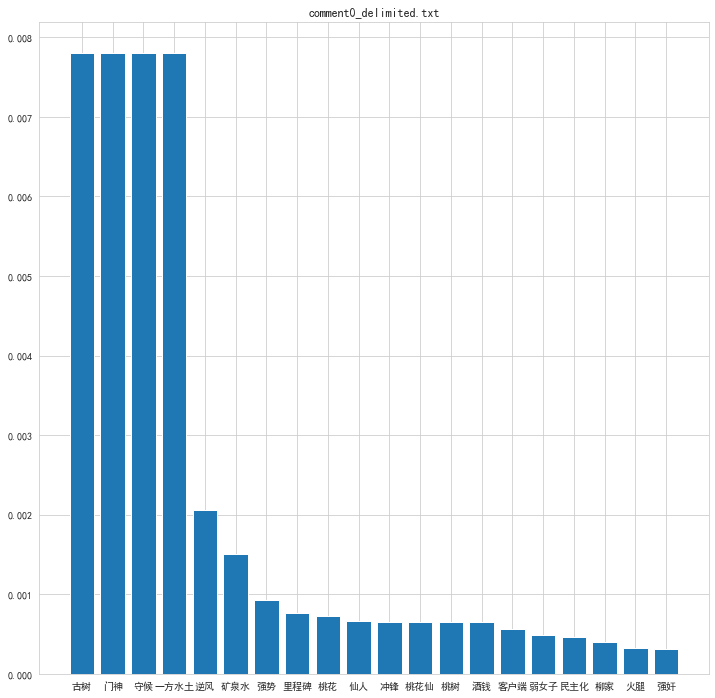

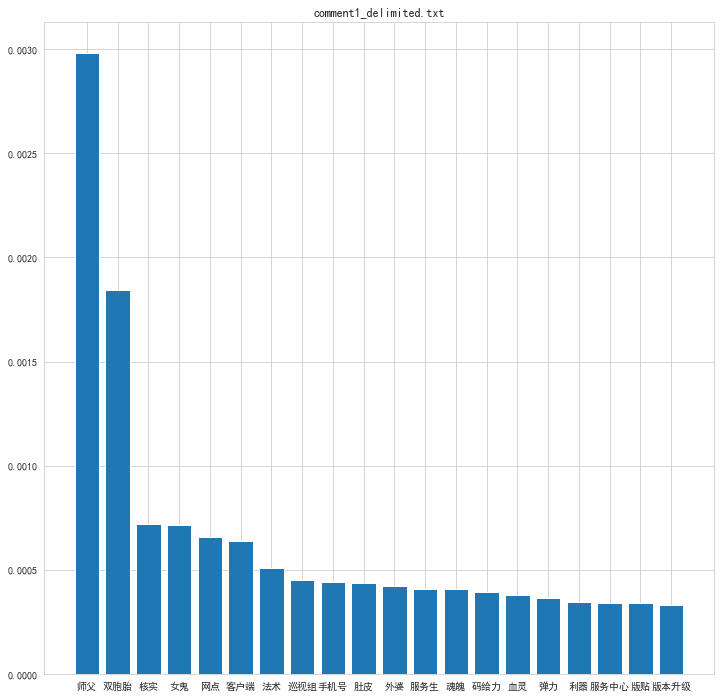

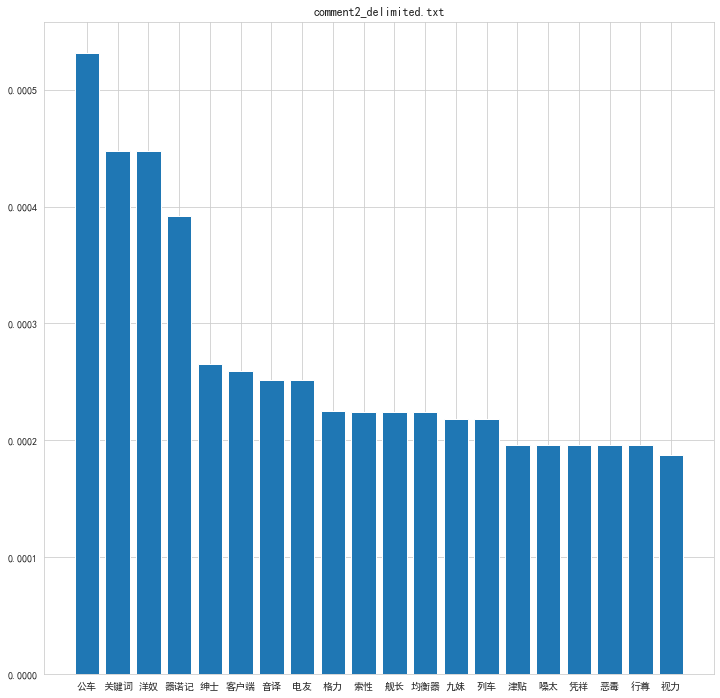

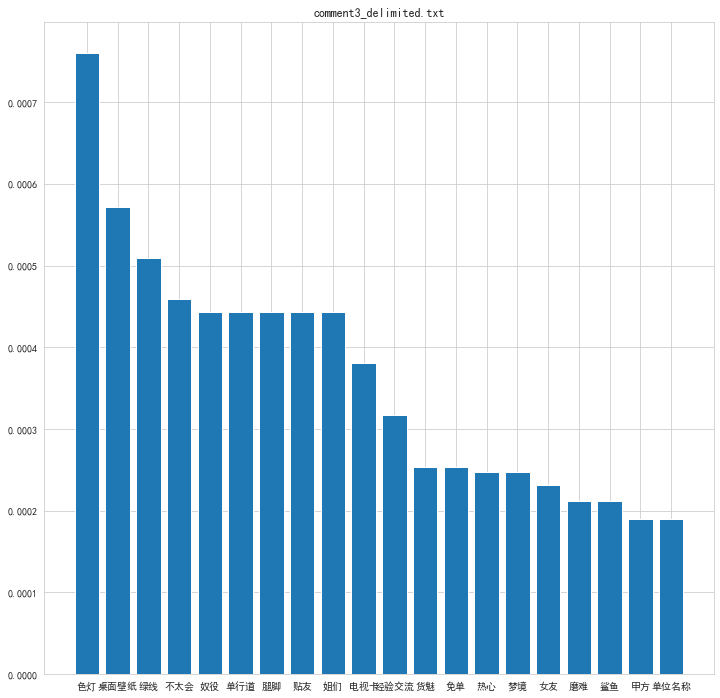

In [12]:
jieba.analyse.set_stop_words('./data/stop_words.txt')
jieba.analyse.set_idf_path('./data/diff_people_comment/kmeans_graph_sage_add_info/idf_corpus/idf.txt')

topK=20
tfidf_dict={}
for file_name in os.listdir('./data/diff_people_comment/kmeans_graph_sage_add_info/idf_corpus/'):
    if file_name in ['idf.txt']:
        continue
    print(file_name)
    content = open(f'./data/diff_people_comment/kmeans_graph_sage_add_info/{file_name}', 'rb').read()
    tags = jieba.analyse.extract_tags(content, topK=topK,allowPOS=['n'],withWeight=True)
    tfidf_dict[file_name]=tags
    ### eda tfidf
    plt.bar(x=[i[0] for i in tags],height=[i[1]for i in tags])
    plt.title(file_name)
    # plt.savefig(f'{info_path}{file_name}_tfidf.png')
    plt.show()
    # break

# 去停用词
# 单一文档使用textrank 提取关键词

comment0_delimited.txt
comment1_delimited.txt
comment2_delimited.txt
comment3_delimited.txt


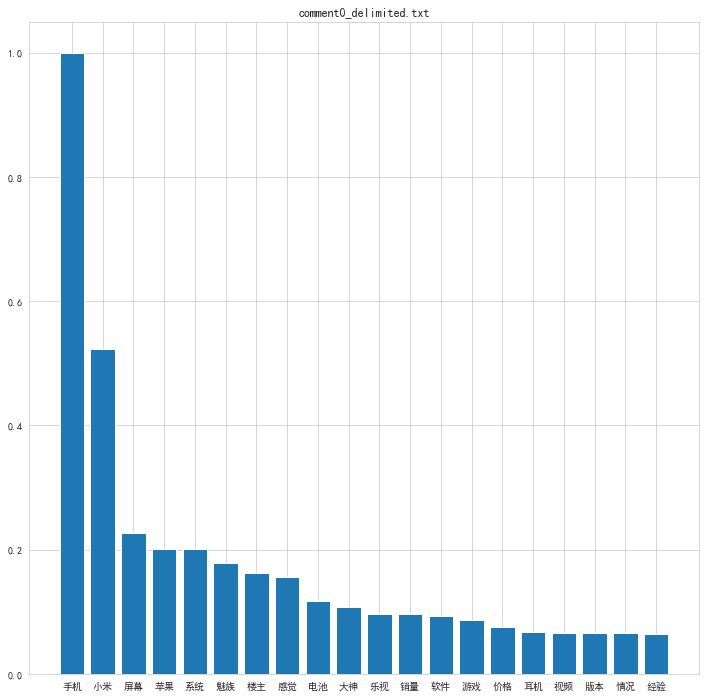

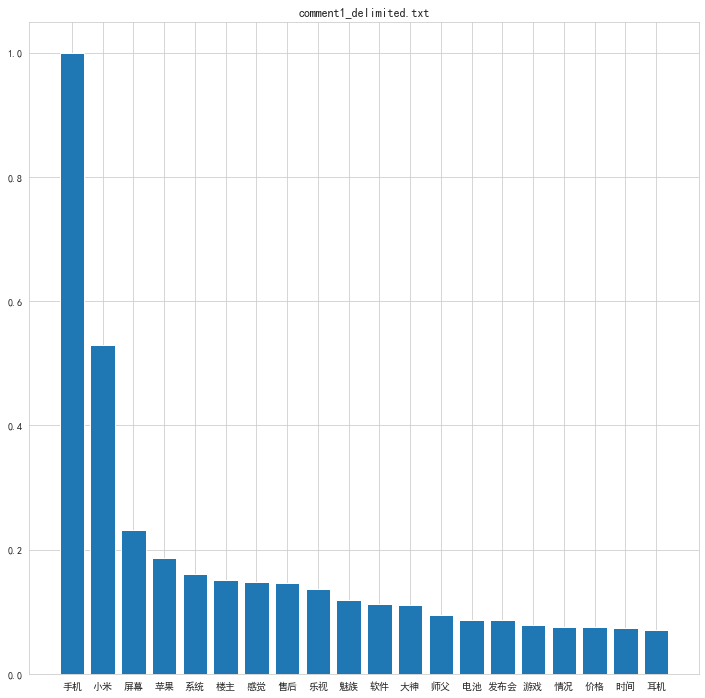

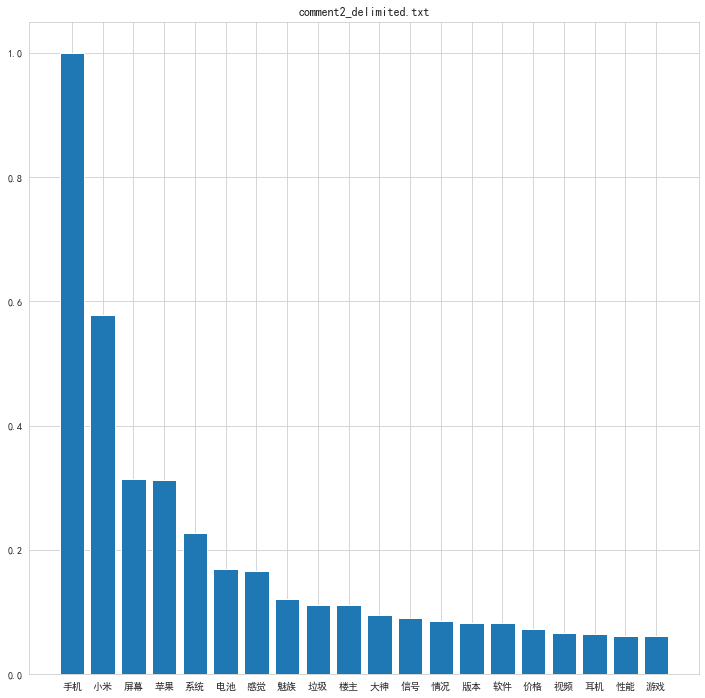

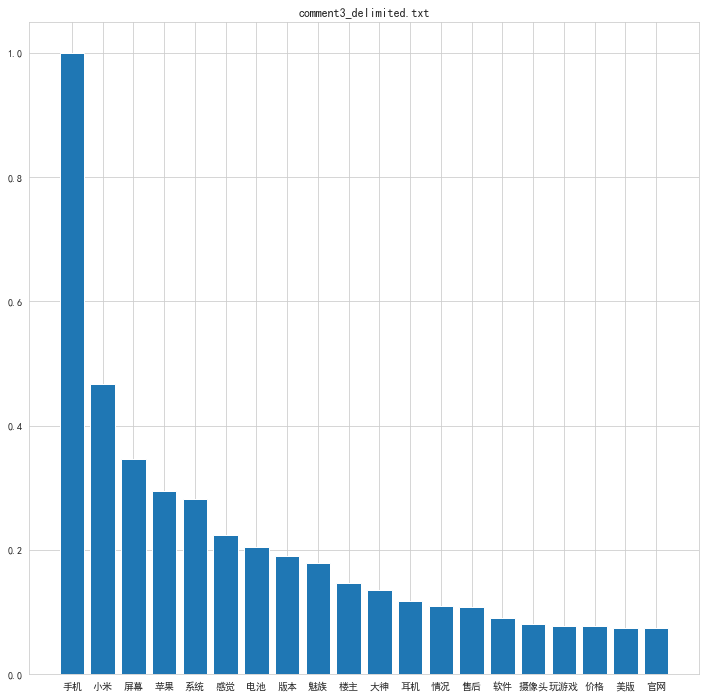

In [89]:
import re
# Wall time: 2min 22s
# sentences='\n'.join(sentences)
# jieba.analyse.set_stop_words('./data/stop_words.txt')
# tr=jieba.analyse.textrank(sentences, withWeight=True,allowPOS=['n'])
# for file_name in os.listdir('./data/diff_people_comment/kmeans_graph_sage_add_info/idf_corpus/'):
for file_name in os.listdir('./data/'):
    if not re.findall('delimited',file_name):
        continue
    print(file_name)
    content = open(f'./data/{file_name}', 'rb').read()
    tr=jieba.analyse.textrank(content, withWeight=True,allowPOS=['n'])
    ### eda textrank
    plt.bar(x=[i[0] for i in tr],height=[i[1]for i in tr])
    plt.title(file_name)
    # plt.savefig(f'{info_path}{file_name}_textrank.png')
    plt.show()
    # break

## 进行LDA建模
## 各个文档中的单词不允许重复
## 输入模式 list of list